In [1]:
%matplotlib inline

# Introducton

This notebook tests the new feature "Recobundles" from https://github.com/nipy/dipy/pull/1443#issuecomment-373049087

Publication:
https://www.sciencedirect.com/science/article/pii/S1053811917305839

# TL;DR

I only tested it on one case and didn't work to refine the template (picked a nice adult subject with susceptibility corrected data and "full" tracks as the template), but here are my initial observations. A transormation to tailor the template to the dataset or refinement of the template to fit  may be needed. The varying performance between the Prisma and Trio of the same subject (same tracking parameters; different scanning parameters) is interesting. This could be a difference in geometry matches of the brain; Prisma cases were corrected for susceptibility distortion. The template was made from a case scanned on the Prisma. 


Notes from visual inspection (N=1 test brain against N=1 template brain on N=2 scanners):

IFOF
- Good on Prisma
- Failed on Trio (same brain, different scanner); not sure why this didn't find any streamlines when the Prisma did

SLF-tp 
- Good on Prisma
- Tested IFOF on another dataset (same brain, different scanner = Trio); not sure why this didn't find any streamlines when the Prisma did

UNCINATE
- Prisma did not perform well (template poor match)
    - More forgiving template?
    - Pre-registration of the region?
    
ARCUATE/SLF COMPLEX (includes 3 tracks: Arcuate, SLF ip, SLF tp)
- Some mixing SLFip vs. Arcuate but reasonably good performance
    - Differential templates? (enforce single-template membership)

ILF 
- includes extra medial projections
- combination of large-ROI ACT may fix this easily (pyAFQ)
- on the Trio dataset this was even worse... need to look into it

ASLANT
- Failed on both Prisma and Trio
- The aslant is a specific shape that may be missed if the initial placement of the template in the AP direction is off

In [2]:
import os
from glob import glob

import nibabel as nib
import numpy as np

from dipy.tracking.distances import bundles_distances_mam
from dipy.tracking.streamline import Streamlines
from dipy.segment.bundles import RecoBundles
from dipy.segment.clustering import qbx_with_merge
from dipy.data import get_data

from IPython.display import display, HTML, Image

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
def make_html(path_list):
    myhtml = ''
    for path in path_list:
        myhtml+='<img src="{}" style="float: left; width: 40%; margin-right: 1%; margin-bottom: 0.5em;"/>'.format(path)
    return myhtml

In [48]:
from dipy.viz import window, actor

def genren(sls, sls2=None, niidata=None, roi1=None, roi2=None, aff=None, putpath=None, show=False, orient=True, colors=[(1,1,1)]):
    
    renderer = window.Renderer()
    
    if len(colors)>1:
        stream_actor = actor.line(sls, colors=colors[1])
    else:
        stream_actor=actor.line(sls)
        
    renderer.add(stream_actor)
    
    if sls2 is not None:
        stream_actor2 = actor.line(sls2, colors=colors[0])
        renderer.add(stream_actor2)
    
    if roi1 is not None and roi2 is not None:
        
        contour_actor1 = actor.contour_from_roi(roi1, affine=aff, color=(1., 1., 0.),
                                          opacity=0.5)
        contour_actor2 = actor.contour_from_roi(roi2, affine=aff, color=(1., 0., 0.),
                                          opacity=0.5)
        renderer.add(contour_actor1)
        renderer.add(contour_actor2)
        
    
    if niidata is not None:
        slice_actor = actor.slicer(niidata, affine=aff)
        renderer.add(slice_actor)

    #renderer.set_camera(position=(-176.42, 118.52, 128.20),
    #                    focal_point=(113.30, 128.31, 76.56),
    #                    view_up=(0.18, 0.00, 0.98))

    if orient:
        axes_actor = actor.axes(scale=(10, 10, 10), colorx=(1, 0, 0), colory=(0, 1, 0), colorz=(0, 0, 1), opacity=1)
        #Create an actor with the coordinate’s system axes where red = x, green = y, blue = z.
        renderer.add(axes_actor)

    if show:
        window.show(renderer, size=(600, 600), reset_camera=False)
    if putpath is not None:
        window.record(renderer, out_path=putpath, size=(600, 600))
    del renderer
    return putpath

In [16]:
def run_rb(templatesls, bucketosls):
    cluster_map = qbx_with_merge(bucketosls, thresholds=[40, 25, 20, 10])

    rb = RecoBundles(bucketosls, cluster_map=cluster_map, clust_thr=10)
    recognized, rec_labels, rec_trans = rb.recognize(model_bundle=templatesls,
                                                         model_clust_thr=5.,
                                                         reduction_thr=10)
    D = bundles_distances_mam(templatesls, recognized)
    
    return recognized

# Find paths/load data

In [6]:
putdir = 'output_Kesh_Test_Recobundles'
if not os.path.exists(putdir):
    os.mkdir(putdir)

In [7]:
def loadtgm_newapi(trkpath):
    trkloaded = nib.streamlines.trk.TrkFile.load(trkpath)
    hdrloaded = trkloaded.header
    tg=trkloaded.tractogram
    return tg

In [112]:
wb_prisma_path = '/Users/kesshijordan/ref_data/interscan_dys/Prisma/TRACKs/Whole_Brain_bs_prob_gt40mm_good.trk'
wb_prisma_path_raw = '/Users/kesshijordan/ref_data/interscan_dys/Prisma/TRACKs/Whole_Brain_bs_prob.trk'
wb_trio_path_raw = '/Users/kesshijordan/ref_data/interscan_dys/Trio/TRACKs/Whole_Brain_bs_prob.trk'

#single case gold standard
gs_prisma_path = '/Users/kesshijordan/ref_data/interscan_dys/Prisma/TRACKs/'
gs_trio_path = '/Users/kesshijordan/ref_data/interscan_dys/Trio/TRACKs/'

#single case template
pathpath = '/Users/kesshijordan/paths/recobundles_template_basepath.txt'
with open(pathpath, 'r') as myfile:
    template_basepath = myfile.read().replace('\n', '').replace('\'','')

Nice Whole Brain Dataset from Subject on Prisma

In [9]:
wb_prisma_tg = loadtgm_newapi(wb_prisma_path)

In [10]:
wb_prisma_sls = wb_prisma_tg.streamlines

## IFOF

Single case template

In [12]:
template = os.path.join(template_basepath, 'IFOF_L.trk')

t_tg_ifof = loadtgm_newapi(template)
t_sls_ifof = t_tg_ifof.streamlines

Find the template IFOF in the whole brain of another patient

In [17]:
rb_prisma_ifof_L = run_rb(t_sls_ifof, wb_prisma_sls)

 Resampled to 20 points
 Size is 217.929 MB
 Duration of resampling is 1.204 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 952146 random streamlines
 Duration 68.021 sec. 

 Streamlines have 6155 centroids
 Total loading duration 0.002 sec. 

## Recognize given bundle ## 

# Cluster model bundle using QBx
 Model bundle has 5375 streamlines
 Distance threshold 5.000
 Resampled to 20 points
 Size is 1.230 MB
 Duration of resampling is 0.011 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 500000 random streamlines
 Duration 0.288 sec. 

 Model bundle has 164 centroids
 Duration 0.299 sec. 

# Reduce search space
 Reduction threshold 10.000
 Reduction distance mdf
 Using MDF
 Number of neighbor streamlines 1451
 Duration 1.064 sec. 

# Local SLR of neighb_streamlines to model
 Square-root of BMD is 7.428
 Number of iterations 40
 Matrix size (400, 600)
[[ 1.136 -0.176 -0.054  6.317]
 [ 0.175  1.137 -0.031  4.388]
 [ 0.058  0

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


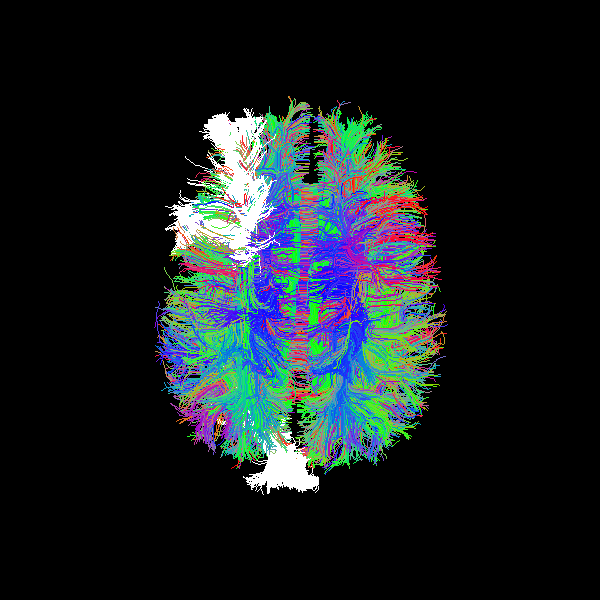

In [18]:
renpath=os.path.join(putdir, 'WB_IFOF_L.png')
genren(wb_prisma_sls[::100], t_sls_ifof, putpath=renpath)
Image(renpath, width=400, height=400)

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


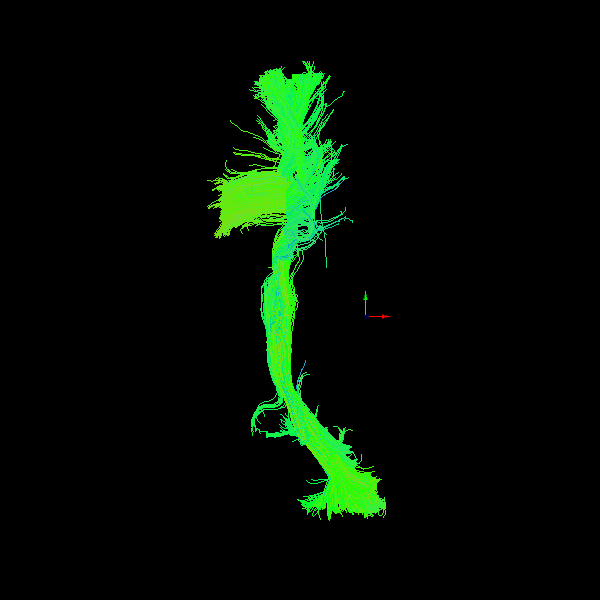

In [19]:
renpath2=os.path.join(putdir, 'template_IFOF_L.png')
genren(t_sls_ifof, putpath=renpath)
Image(renpath, width=400, height=400)

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


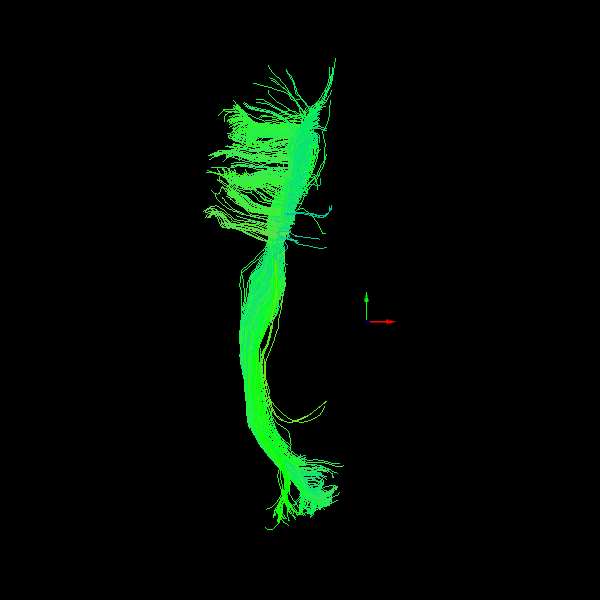

In [20]:
renpath=os.path.join(putdir, 'recognized_IFOF_L.png')
genren(rb_prisma_ifof_L, putpath=renpath)
Image(renpath, width=400, height=400)

## Test with a messier dataset of streamlines (raw output)

In [21]:
wb_rawprisma_tg = loadtgm_newapi(wb_prisma_path_raw)

In [22]:
wb_rawprisma_sls = wb_rawprisma_tg.streamlines

In [23]:
rb_rawprisma_ifof_L = run_rb(t_sls_ifof, wb_rawprisma_sls)

 Resampled to 20 points
 Size is 1497.912 MB
 Duration of resampling is 6.461 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 6544476 random streamlines
 Duration 329.434 sec. 

 Streamlines have 6789 centroids
 Total loading duration 0.002 sec. 

## Recognize given bundle ## 

# Cluster model bundle using QBx
 Model bundle has 5375 streamlines
 Distance threshold 5.000
 Resampled to 20 points
 Size is 1.230 MB
 Duration of resampling is 0.009 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 500000 random streamlines
 Duration 0.212 sec. 

 Model bundle has 162 centroids
 Duration 0.222 sec. 

# Reduce search space
 Reduction threshold 10.000
 Reduction distance mdf
 Using MDF
 Number of neighbor streamlines 583
 Duration 1.292 sec. 

# Local SLR of neighb_streamlines to model
 Square-root of BMD is 8.132
 Number of iterations 66
 Matrix size (400, 583)
[[ 1.085 -0.215  0.107  5.821]
 [ 0.222  1.087 -0.069 -0.242]
 [-0.091 

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


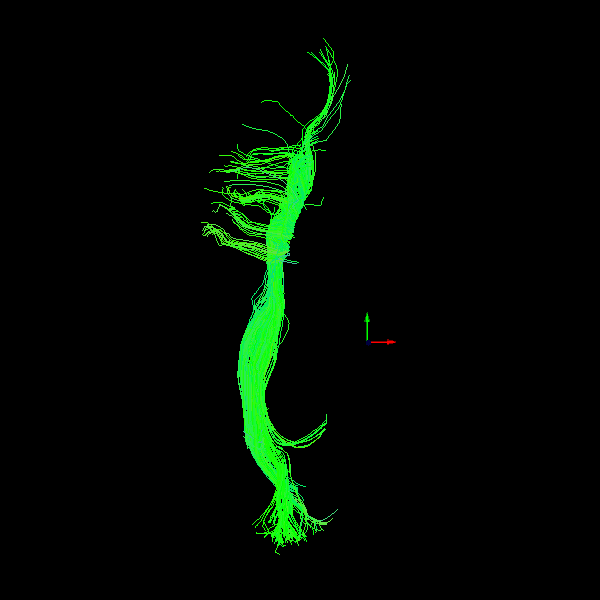

In [24]:
renpath=os.path.join(putdir, 'recognized_IFOF_L_RAW.png')
genren(rb_rawprisma_ifof_L, putpath=renpath)
Image(renpath, width=400, height=400)

## Test with a rescan of the same brain (different scanner/sequence)

In [25]:
wb_rawtrio_tg = loadtgm_newapi(wb_trio_path_raw)

In [26]:
wb_rawtrio_sls = wb_rawtrio_tg.streamlines

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
/Users/kesshijordan/anaconda/lib/python3.6/site-packages/dipy/viz/colormap.py:233: RuntimeWarning: invalid value encountered in true_divide
  orient = np.abs(orient / np.linalg.norm(orient))


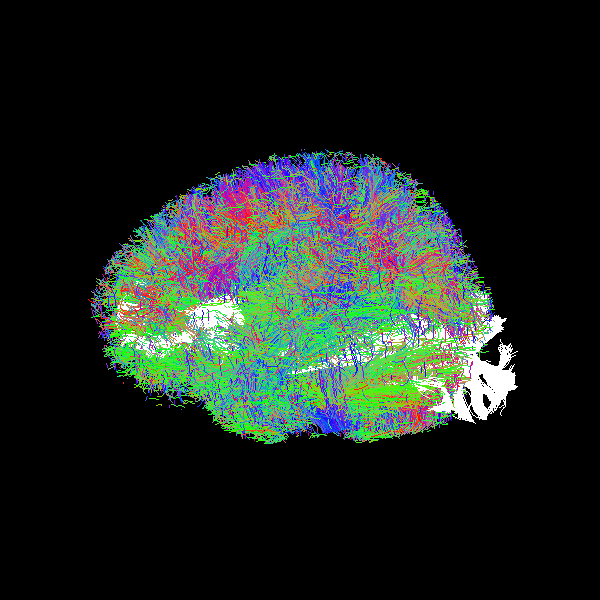

In [30]:
renpath=os.path.join(putdir, 'WB_IFOF_L_TRIO.png')
genren(wb_rawtrio_sls[::100], t_sls_ifof, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

In [27]:
rb_rawtrio_ifof_L = run_rb(t_sls_ifof, wb_rawtrio_sls)

 Resampled to 20 points
 Size is 1033.419 MB
 Duration of resampling is 3.813 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 4515075 random streamlines
 Duration 248.639 sec. 

 Streamlines have 8363 centroids
 Total loading duration 0.005 sec. 

## Recognize given bundle ## 

# Cluster model bundle using QBx
 Model bundle has 5375 streamlines
 Distance threshold 5.000
 Resampled to 20 points
 Size is 1.230 MB
 Duration of resampling is 0.018 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 500000 random streamlines
 Duration 0.251 sec. 

 Model bundle has 160 centroids
 Duration 0.270 sec. 

# Reduce search space
 Reduction threshold 10.000
 Reduction distance mdf
 Using MDF
 You have no neighbor streamlines... No bundle recognition


Not sure why this one failed.. There are definitely IFOF bundles in there.

In [ ]:
renpath=os.path.join(putdir, 'recognized_IFOF_L_RAW_TRIO.png')
genren(rb_rawtrio_ifof_L, putpath=renpath)
Image(renpath, width=400, height=400)

# ILF

In [79]:
template = os.path.join(template_basepath, 'ILF_L.trk')

t_tg_ilf = loadtgm_newapi(template)
t_sls_ilf = t_tg_ilf.streamlines

In [80]:
rb_prisma_ilf_L = run_rb(t_sls_ilf, wb_prisma_sls)

 Resampled to 20 points
 Size is 217.929 MB
 Duration of resampling is 1.259 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 952146 random streamlines
 Duration 81.002 sec. 

 Streamlines have 6156 centroids
 Total loading duration 0.003 sec. 

## Recognize given bundle ## 

# Cluster model bundle using QBx
 Model bundle has 3289 streamlines
 Distance threshold 5.000
 Resampled to 20 points
 Size is 0.753 MB
 Duration of resampling is 0.010 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 500000 random streamlines
 Duration 0.180 sec. 

 Model bundle has 90 centroids
 Duration 0.191 sec. 

# Reduce search space
 Reduction threshold 10.000
 Reduction distance mdf
 Using MDF
 Number of neighbor streamlines 13164
 Duration 1.127 sec. 

# Local SLR of neighb_streamlines to model
 Square-root of BMD is 6.910
 Number of iterations 74
 Matrix size (400, 600)
[[  0.618  -0.094   0.611  -5.533]
 [  0.004   0.865   0.128   6.615]
 [ 

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


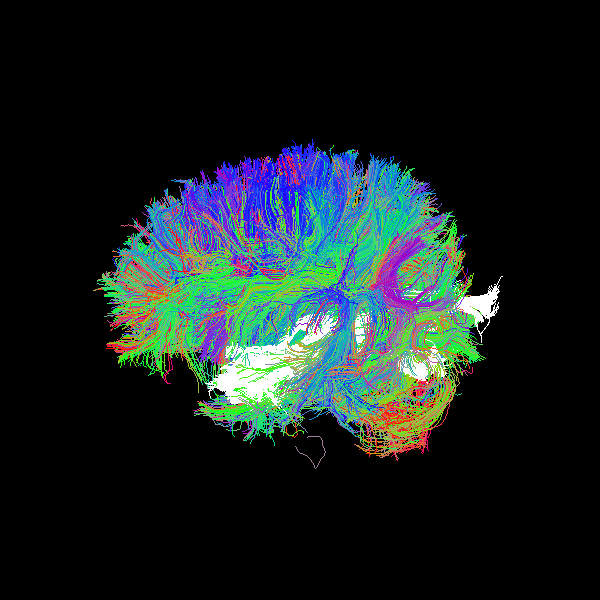

In [89]:
renpath=os.path.join(putdir, 'WB_ILF_L.png')
genren(wb_prisma_sls[::100], t_sls_ilf, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


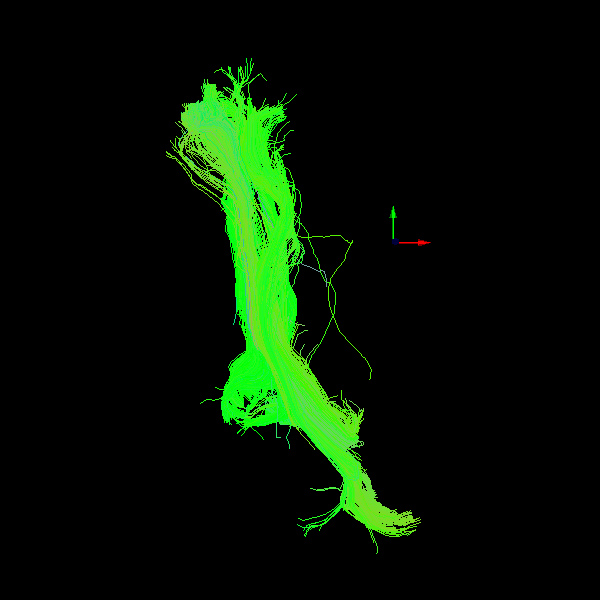

In [92]:
renpath=os.path.join(putdir, 'template_ILF_L.png')
genren(t_sls_ilf, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


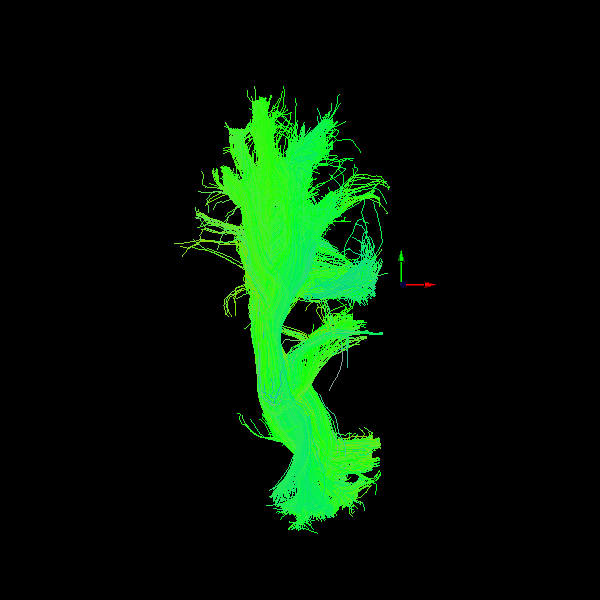

In [93]:
renpath=os.path.join(putdir, 'recognized_ILF_L.png')
genren(rb_prisma_ilf_L, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

Includes extra medial projections that should be removed

## Try ILF with Trio Data

In [95]:
rb_trio_ilf_L = run_rb(t_sls_ilf, wb_rawtrio_sls)

 Resampled to 20 points
 Size is 1033.419 MB
 Duration of resampling is 3.854 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 4515075 random streamlines
 Duration 232.933 sec. 

 Streamlines have 8371 centroids
 Total loading duration 0.002 sec. 

## Recognize given bundle ## 

# Cluster model bundle using QBx
 Model bundle has 3289 streamlines
 Distance threshold 5.000
 Resampled to 20 points
 Size is 0.753 MB
 Duration of resampling is 0.005 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 500000 random streamlines
 Duration 0.101 sec. 

 Model bundle has 81 centroids
 Duration 0.107 sec. 

# Reduce search space
 Reduction threshold 10.000
 Reduction distance mdf
 Using MDF
 Number of neighbor streamlines 371
 Duration 0.757 sec. 

# Local SLR of neighb_streamlines to model
 Square-root of BMD is 8.234
 Number of iterations 33
 Matrix size (400, 371)
[[  0.626  -0.542   0.868 -10.659]
 [  0.573   1.029   0.229  29.624]
 [

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
/Users/kesshijordan/anaconda/lib/python3.6/site-packages/dipy/viz/colormap.py:233: RuntimeWarning: invalid value encountered in true_divide
  orient = np.abs(orient / np.linalg.norm(orient))


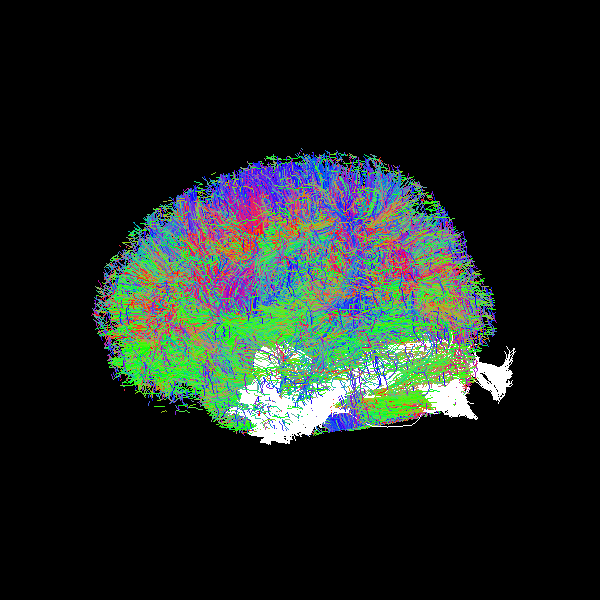

In [100]:
renpath=os.path.join(putdir, 'WB_ILF_L_TRIO.png')
genren(wb_rawtrio_sls[::100], t_sls_ilf, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


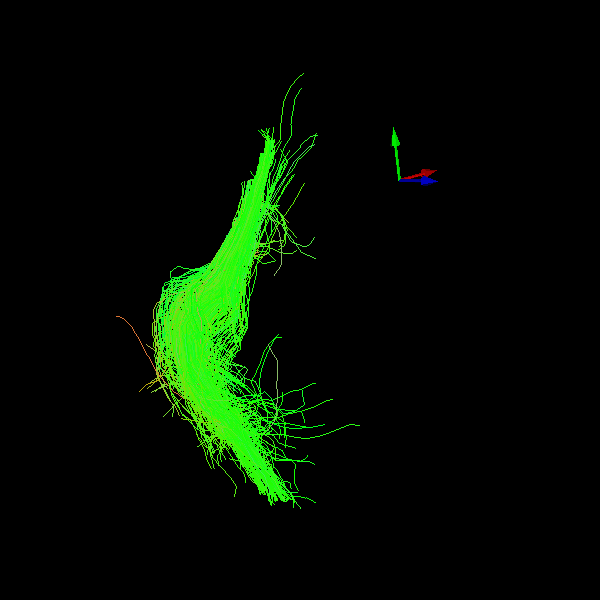

In [102]:
renpath=os.path.join(putdir, 'recognized_ILF_L_TRIO.png')
genren(rb_trio_ilf_L, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

Nope

# Uncinate

In [70]:
template = os.path.join(template_basepath, 'Uncinate_L.trk')

t_tg_unc = loadtgm_newapi(template)
t_sls_unc = t_tg_unc.streamlines

In [73]:
rb_prisma_unc_L = run_rb(t_sls_unc, wb_prisma_sls)

 Resampled to 20 points
 Size is 217.929 MB
 Duration of resampling is 1.293 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 952146 random streamlines
 Duration 79.234 sec. 

 Streamlines have 6098 centroids
 Total loading duration 0.001 sec. 

## Recognize given bundle ## 

# Cluster model bundle using QBx
 Model bundle has 878 streamlines
 Distance threshold 5.000
 Resampled to 20 points
 Size is 0.201 MB
 Duration of resampling is 0.001 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 500000 random streamlines
 Duration 0.026 sec. 

 Model bundle has 35 centroids
 Duration 0.029 sec. 

# Reduce search space
 Reduction threshold 10.000
 Reduction distance mdf
 Using MDF
 Number of neighbor streamlines 5
 Duration 0.211 sec. 

# Local SLR of neighb_streamlines to model
 Square-root of BMD is 10.724
 Number of iterations 28
 Matrix size (400, 5)
[[  0.843   0.694   0.499 -19.238]
 [ -0.098   0.774  -0.912   0.312]
 [ -0.849

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


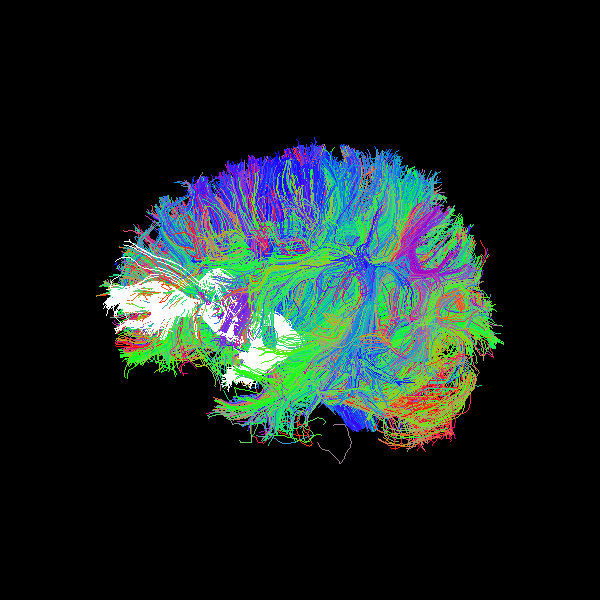

In [72]:
renpath=os.path.join(putdir, 'WB_UNC_L.png')
genren(wb_prisma_sls[::100], t_sls_unc, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


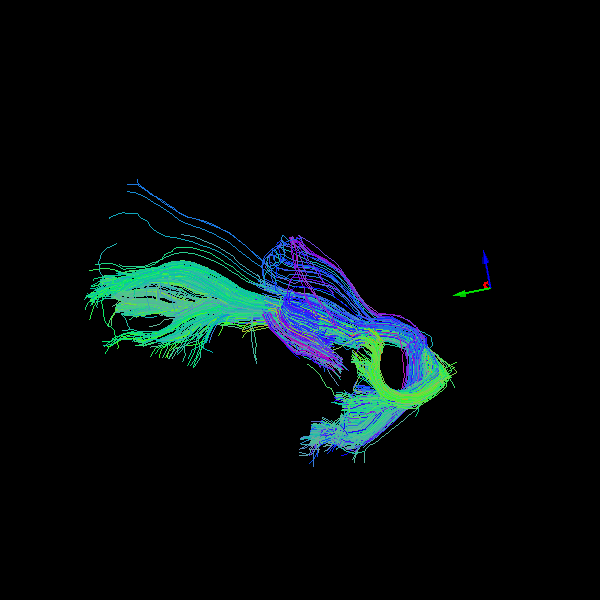

In [74]:
renpath=os.path.join(putdir, 'template_UNC_L.png')
genren(t_sls_unc, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


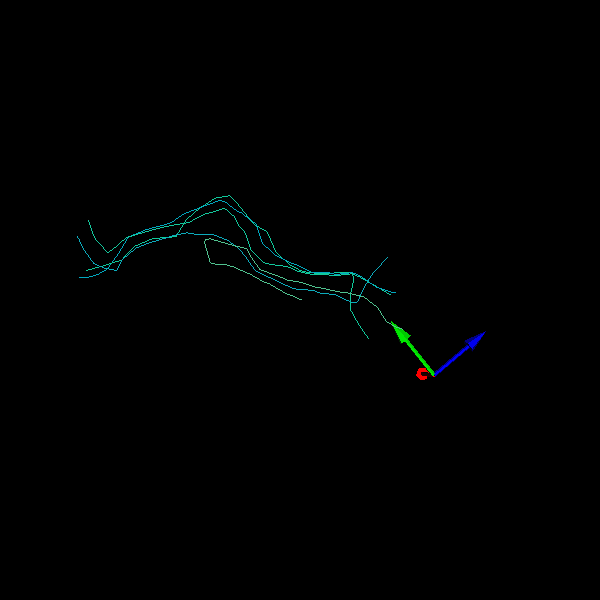

In [75]:
renpath=os.path.join(putdir, 'recognized_UNC_L.png')
genren(rb_prisma_unc_L, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

Uncinate failed. Note: there is not a very good correspondence between the template subject and this one in the ATL/OFC area where the uncinate curves around. A more inclusive template may help this

## Trio Uncinate

In [103]:
rb_trio_unc_L = run_rb(t_sls_unc, wb_rawtrio_sls)

 Resampled to 20 points
 Size is 1033.419 MB
 Duration of resampling is 3.672 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 4515075 random streamlines
 Duration 265.329 sec. 

 Streamlines have 8364 centroids
 Total loading duration 0.002 sec. 

## Recognize given bundle ## 

# Cluster model bundle using QBx
 Model bundle has 878 streamlines
 Distance threshold 5.000
 Resampled to 20 points
 Size is 0.201 MB
 Duration of resampling is 0.002 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 500000 random streamlines
 Duration 0.023 sec. 

 Model bundle has 34 centroids
 Duration 0.026 sec. 

# Reduce search space
 Reduction threshold 10.000
 Reduction distance mdf
 Using MDF
 Number of neighbor streamlines 7498
 Duration 0.418 sec. 

# Local SLR of neighb_streamlines to model
 Square-root of BMD is 7.565
 Number of iterations 39
 Matrix size (400, 600)
[[  0.684  -0.235   0.342  -3.157]
 [  0.344   0.69   -0.213  21.614]
 [

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
/Users/kesshijordan/anaconda/lib/python3.6/site-packages/dipy/viz/colormap.py:233: RuntimeWarning: invalid value encountered in true_divide
  orient = np.abs(orient / np.linalg.norm(orient))


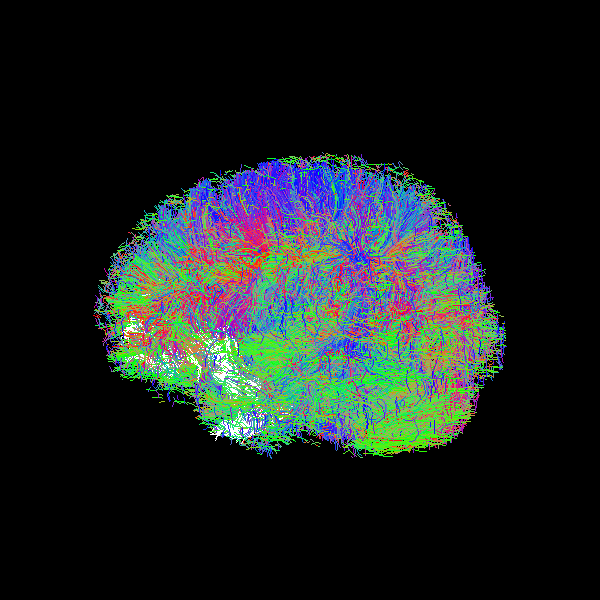

In [104]:
renpath=os.path.join(putdir, 'WB_UNC_L_TRIO.png')
genren(wb_rawtrio_sls[::100], t_sls_unc, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


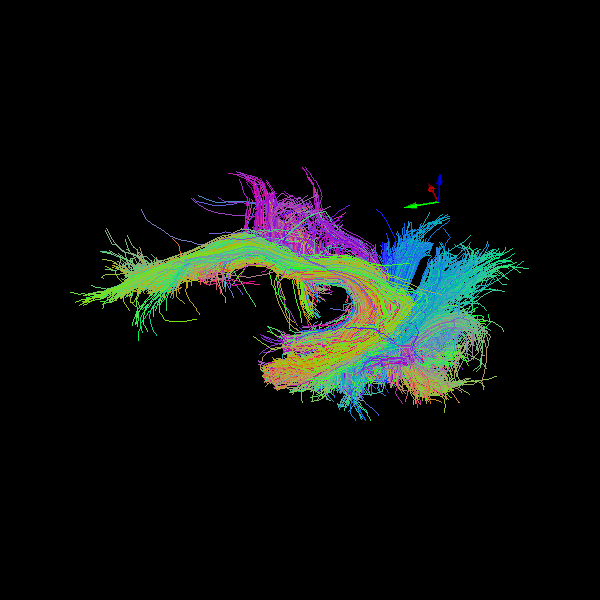

In [105]:
renpath=os.path.join(putdir, 'recognized_UNC_L_TRIO.png')
genren(rb_trio_unc_L, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

Decent but lots of extra stuff

# Aslant

In [84]:
template = os.path.join(template_basepath, 'Aslant_L.trk')

t_tg_aslant = loadtgm_newapi(template)
t_sls_aslant = t_tg_aslant.streamlines

In [85]:
rb_prisma_aslant_L = run_rb(t_sls_aslant, wb_prisma_sls)

 Resampled to 20 points
 Size is 217.929 MB
 Duration of resampling is 1.129 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 952146 random streamlines
 Duration 63.597 sec. 

 Streamlines have 6133 centroids
 Total loading duration 0.002 sec. 

## Recognize given bundle ## 

# Cluster model bundle using QBx
 Model bundle has 1792 streamlines
 Distance threshold 5.000
 Resampled to 20 points
 Size is 0.410 MB
 Duration of resampling is 0.003 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 500000 random streamlines
 Duration 0.042 sec. 

 Model bundle has 16 centroids
 Duration 0.045 sec. 

# Reduce search space
 Reduction threshold 10.000
 Reduction distance mdf
 Using MDF
 You have no neighbor streamlines... No bundle recognition


/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


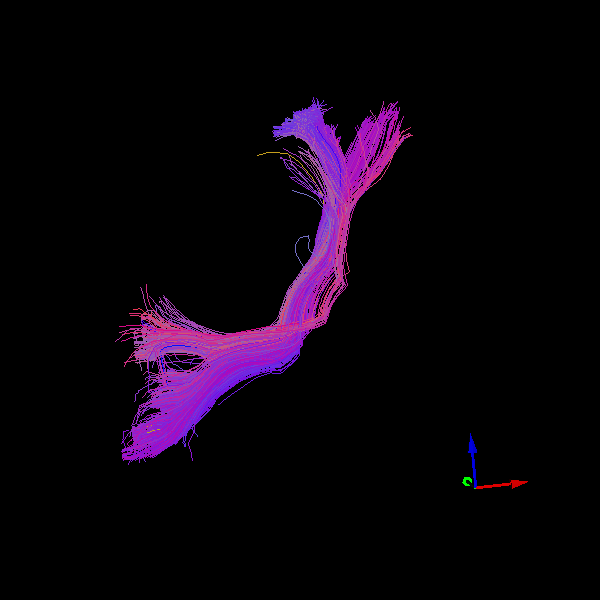

In [87]:
renpath=os.path.join(putdir, 'template_Aslant_L.png')
genren(t_sls_aslant, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

In [ ]:
renpath=os.path.join(putdir, 'recognized_Aslant_L.png')
genren(rb_prisma_aslant_L, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

This failed

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


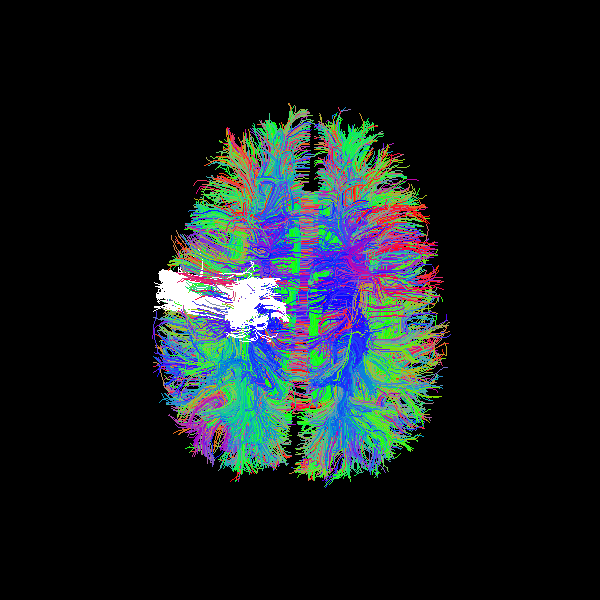

In [86]:
renpath=os.path.join(putdir, 'WB_Aslant_L.png')
genren(wb_prisma_sls[::100], t_sls_aslant, putpath=renpath)
Image(renpath, width=400, height=400)

In [115]:
gold=glob(os.path.join(gs_prisma_path, 'Aslant_prob.trk'))[0]

gs_tg = loadtgm_newapi(gold)
gs_sls = gs_tg.streamlines

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


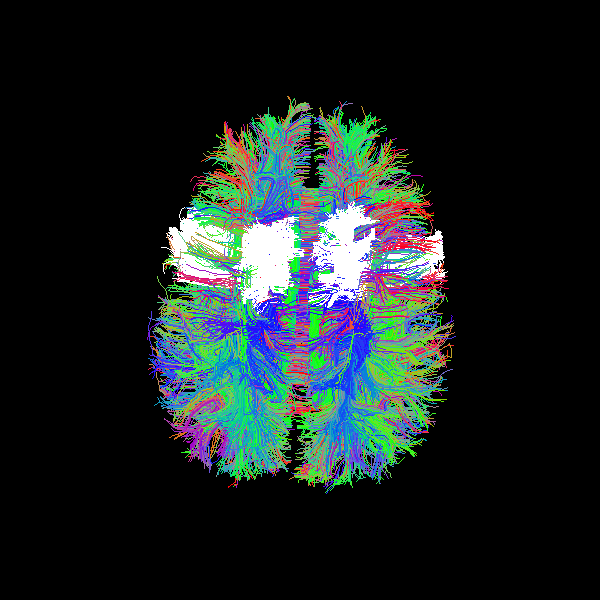

In [118]:
renpath=os.path.join(putdir, 'gold_Aslant_L_PRISMA_WHOLEBRAIN.png')
genren(wb_prisma_sls[::100], gs_sls, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

## Trio Aslant

In [106]:
rb_trio_aslant_L = run_rb(t_sls_aslant, wb_rawtrio_sls)

 Resampled to 20 points
 Size is 1033.419 MB
 Duration of resampling is 3.369 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 4515075 random streamlines
 Duration 272.641 sec. 

 Streamlines have 8354 centroids
 Total loading duration 0.002 sec. 

## Recognize given bundle ## 

# Cluster model bundle using QBx
 Model bundle has 1792 streamlines
 Distance threshold 5.000
 Resampled to 20 points
 Size is 0.410 MB
 Duration of resampling is 0.004 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 500000 random streamlines
 Duration 0.041 sec. 

 Model bundle has 17 centroids
 Duration 0.045 sec. 

# Reduce search space
 Reduction threshold 10.000
 Reduction distance mdf
 Using MDF
 You have no neighbor streamlines... No bundle recognition


/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
/Users/kesshijordan/anaconda/lib/python3.6/site-packages/dipy/viz/colormap.py:233: RuntimeWarning: invalid value encountered in true_divide
  orient = np.abs(orient / np.linalg.norm(orient))


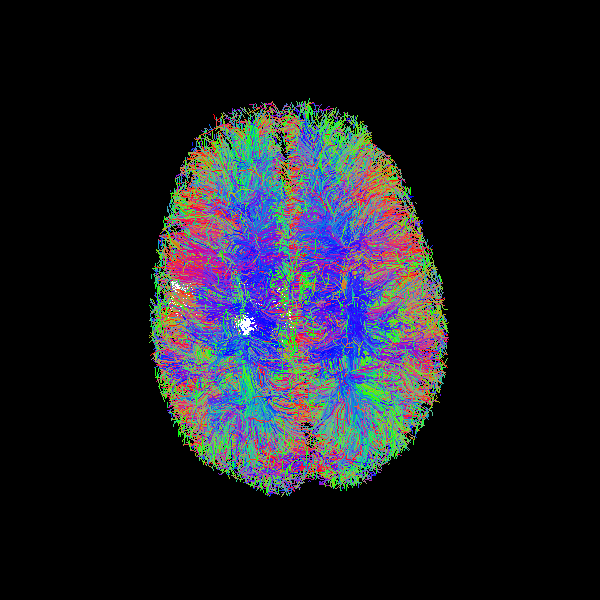

In [108]:
renpath=os.path.join(putdir, 'WB_Aslant_L_TRIO.png')
genren(wb_rawtrio_sls[::100], t_sls_aslant, putpath=renpath)
Image(renpath, width=400, height=400)

Not an expert on this track, but it looks a little posterior to me

In [113]:
gold=glob(os.path.join(gs_trio_path, 'Aslant_prob.trk'))[0]

gs_tg = loadtgm_newapi(gold)
gs_sls = gs_tg.streamlines

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
/Users/kesshijordan/anaconda/lib/python3.6/site-packages/dipy/viz/colormap.py:233: RuntimeWarning: invalid value encountered in true_divide
  orient = np.abs(orient / np.linalg.norm(orient))


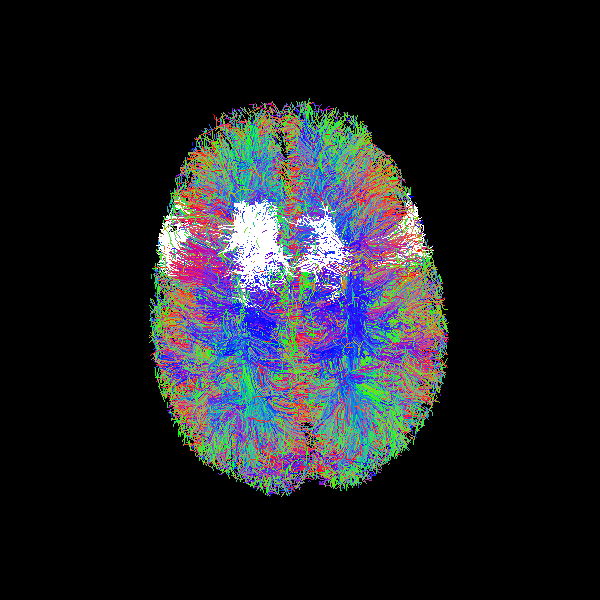

In [114]:
renpath=os.path.join(putdir, 'gold_Aslant_L_TRIO_WHOLEBRAIN.png')
genren(wb_rawtrio_sls[::100], gs_sls, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

yup... it's a little posterior... need a way to guarantee this linear reg starts close enought to find it. (This data isn't susceptibility-corrected and I'm pretty sure it has a P-A phase encode direction; not sure how much that elongated the frontal lobe)

# Arcuate

In [31]:
template = os.path.join(template_basepath, 'Arcuate_L.trk')

t_tg_arcuate = loadtgm_newapi(template)
t_sls_arcuate = t_tg_arcuate.streamlines

In [33]:
rb_prisma_arcuate_L = run_rb(t_sls_arcuate, wb_prisma_sls)

 Resampled to 20 points
 Size is 217.929 MB
 Duration of resampling is 1.171 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 952146 random streamlines
 Duration 68.205 sec. 

 Streamlines have 6121 centroids
 Total loading duration 0.003 sec. 

## Recognize given bundle ## 

# Cluster model bundle using QBx
 Model bundle has 19566 streamlines
 Distance threshold 5.000
 Resampled to 20 points
 Size is 4.478 MB
 Duration of resampling is 0.043 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 500000 random streamlines
 Duration 1.697 sec. 

 Model bundle has 310 centroids
 Duration 1.741 sec. 

# Reduce search space
 Reduction threshold 10.000
 Reduction distance mdf
 Using MDF
 Number of neighbor streamlines 4716
 Duration 2.840 sec. 

# Local SLR of neighb_streamlines to model
 Square-root of BMD is 9.098
 Number of iterations 47
 Matrix size (400, 600)
[[ 1.115 -0.151  0.011  5.52 ]
 [ 0.15   1.085 -0.256 -5.741]
 [ 0.024  

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


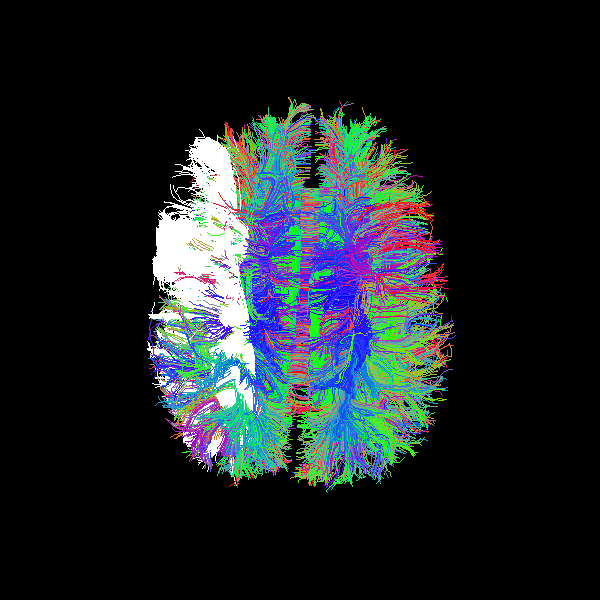

In [34]:
renpath=os.path.join(putdir, 'WB_Arcuate_L.png')
genren(wb_prisma_sls[::100], t_sls_arcuate, putpath=renpath)
Image(renpath, width=400, height=400)

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


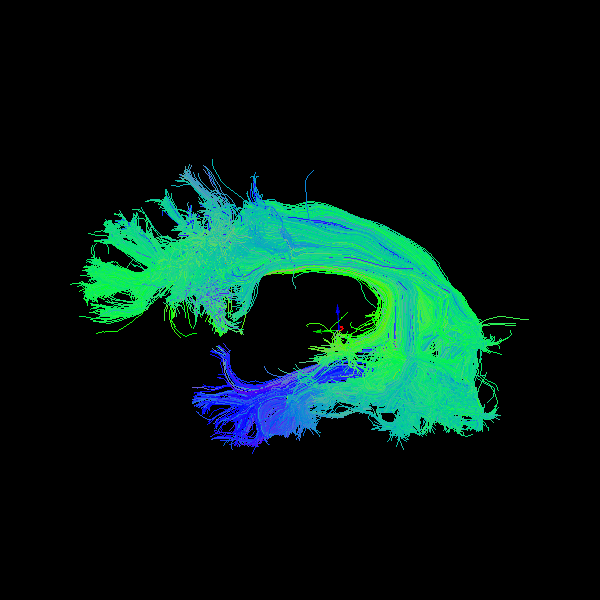

In [35]:
renpath=os.path.join(putdir, 'template_Arcuate_L.png')
genren(t_sls_arcuate, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


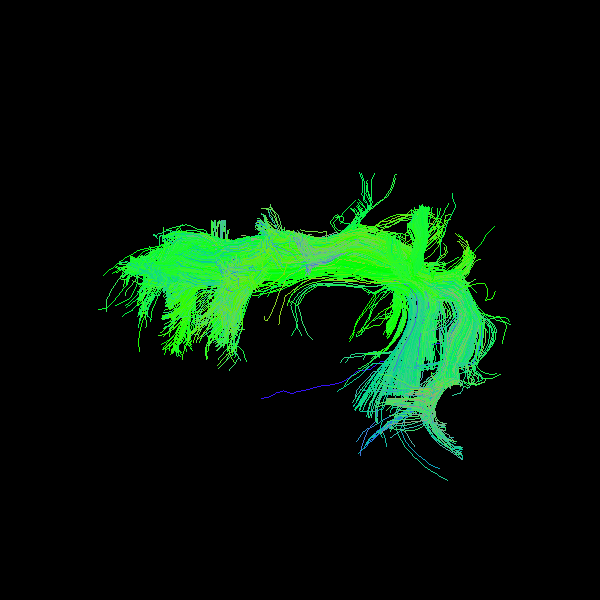

In [36]:
renpath=os.path.join(putdir, 'recognized_Arcuate_L.png')
genren(rb_prisma_arcuate_L, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

In [37]:
gold=glob(os.path.join(gs_prisma_path, 'Arcuate_prob.trk'))[0]

gs_tg = loadtgm_newapi(gold)
gs_sls = gs_tg.streamlines

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


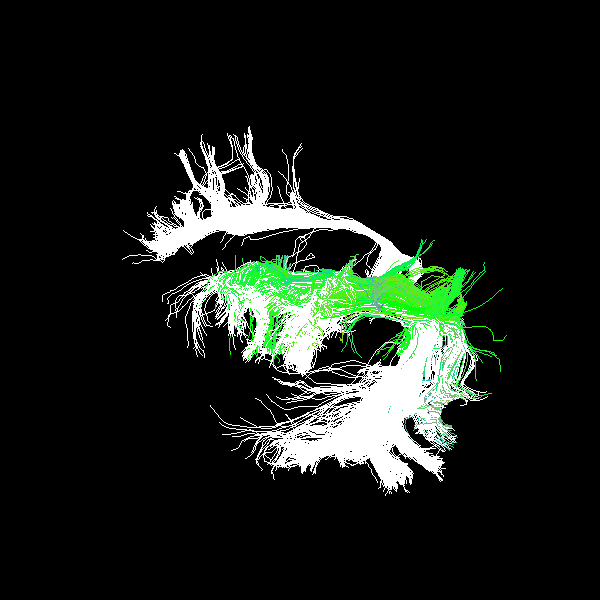

In [38]:
renpath=os.path.join(putdir, 'gold_Arcuate_L.png')
genren(rb_prisma_arcuate_L, gs_sls, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

This one has bundles belonging to multiple tracks: the Arcuate and also the SLF-ip (also called SLF 2&3 and Anterior SLF). Sub-bundles of these tracks are quite similar in shape; the STG projection of the Arcuate and the SLF3, in particular. 

# SLF-IP

In [39]:
template = os.path.join(template_basepath, 'SLF_IP_L.trk')

t_tg_slfip = loadtgm_newapi(template)
t_sls_slfip = t_tg_slfip.streamlines

In [40]:
rb_prisma_slfip_L = run_rb(t_sls_slfip, wb_prisma_sls)

 Resampled to 20 points
 Size is 217.929 MB
 Duration of resampling is 1.384 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 952146 random streamlines
 Duration 73.557 sec. 

 Streamlines have 6134 centroids
 Total loading duration 0.002 sec. 

## Recognize given bundle ## 

# Cluster model bundle using QBx
 Model bundle has 9201 streamlines
 Distance threshold 5.000
 Resampled to 20 points
 Size is 2.106 MB
 Duration of resampling is 0.013 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 500000 random streamlines
 Duration 0.396 sec. 

 Model bundle has 169 centroids
 Duration 0.410 sec. 

# Reduce search space
 Reduction threshold 10.000
 Reduction distance mdf
 Using MDF
 Number of neighbor streamlines 4767
 Duration 1.380 sec. 

# Local SLR of neighb_streamlines to model
 Square-root of BMD is 8.002
 Number of iterations 51
 Matrix size (400, 600)
[[ 0.963 -0.142 -0.051  2.935]
 [ 0.124  0.933 -0.256 -6.305]
 [ 0.086  0

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


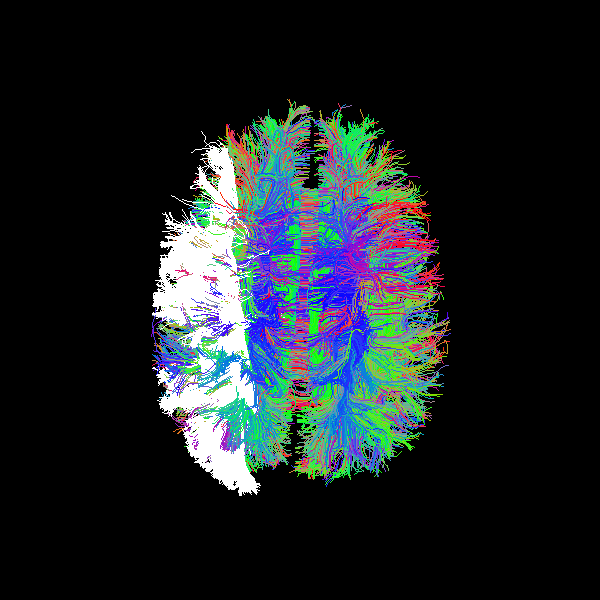

In [41]:
renpath=os.path.join(putdir, 'WB_SLFIP_L.png')
genren(wb_prisma_sls[::100], t_sls_slfip, putpath=renpath)
Image(renpath, width=400, height=400)

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


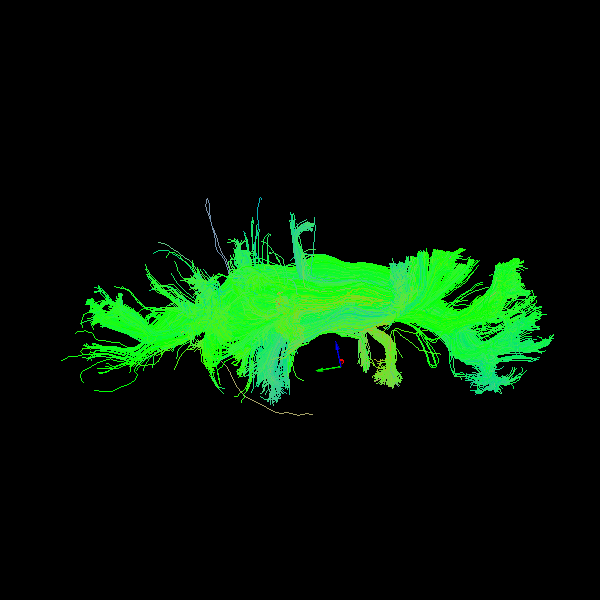

In [43]:
renpath=os.path.join(putdir, 'template_SLFIP_L.png')
genren(t_sls_slfip, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


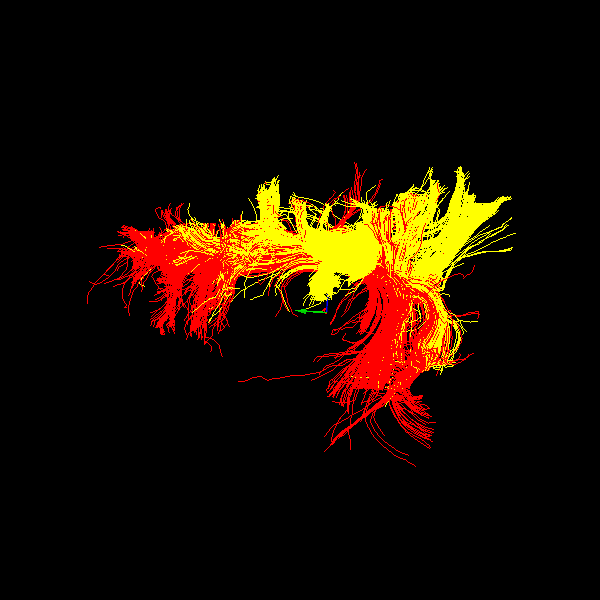

In [68]:
renpath=os.path.join(putdir, 'Arcuate_vs_SLFIP_L.png')
genren(rb_prisma_arcuate_L, rb_prisma_slfip_L, putpath=renpath, show=True, colors=[(1,1,0),(1,0,0)])
Image(renpath, width=400, height=400)

# SLF-tp

In [57]:
template = os.path.join(template_basepath, 'SLF-tp_L.trk')
t_tg_slftp = loadtgm_newapi(template)
t_sls_slftp = t_tg_slftp.streamlines

In [58]:
rb_prisma_slftp_L = run_rb(t_sls_slftp, wb_prisma_sls)

 Resampled to 20 points
 Size is 217.929 MB
 Duration of resampling is 1.150 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 952146 random streamlines
 Duration 73.934 sec. 

 Streamlines have 6131 centroids
 Total loading duration 0.002 sec. 

## Recognize given bundle ## 

# Cluster model bundle using QBx
 Model bundle has 2226 streamlines
 Distance threshold 5.000
 Resampled to 20 points
 Size is 0.509 MB
 Duration of resampling is 0.003 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 500000 random streamlines
 Duration 0.067 sec. 

 Model bundle has 27 centroids
 Duration 0.071 sec. 

# Reduce search space
 Reduction threshold 10.000
 Reduction distance mdf
 Using MDF
 Number of neighbor streamlines 7081
 Duration 0.283 sec. 

# Local SLR of neighb_streamlines to model
 Square-root of BMD is 5.624
 Number of iterations 58
 Matrix size (400, 600)
[[  0.803   0.296  -0.313   1.254]
 [ -0.303   0.858   0.035 -10.405]
 [  

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


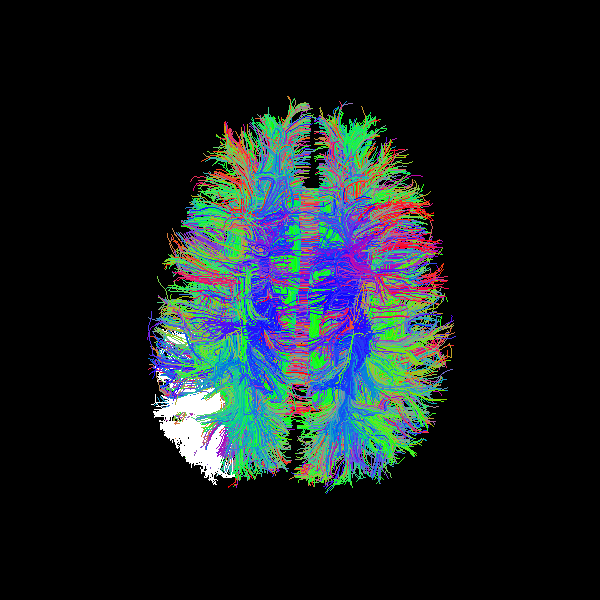

In [59]:
renpath=os.path.join(putdir, 'WB_SLFTP_L.png')
genren(wb_prisma_sls[::100], t_sls_slftp, putpath=renpath)
Image(renpath, width=400, height=400)

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


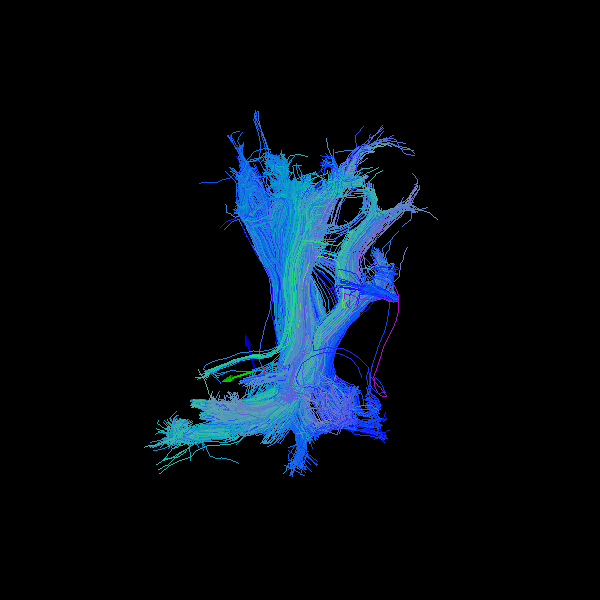

In [60]:
renpath=os.path.join(putdir, 'template_SLFTP_L.png')
genren(t_sls_slftp, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


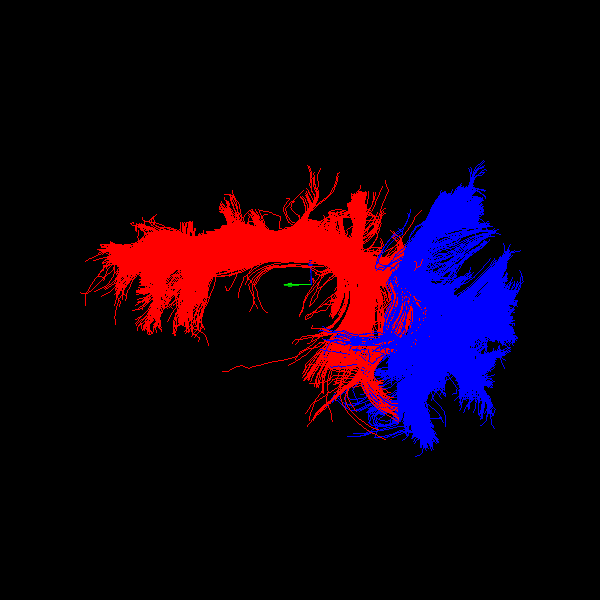

In [67]:
renpath=os.path.join(putdir, 'Arcuate_vs_SLFTP_L.png')
genren(rb_prisma_arcuate_L, rb_prisma_slftp_L, putpath=renpath, show=True, colors=[(0,0,1),(1,0,0)])
Image(renpath, width=400, height=400)

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


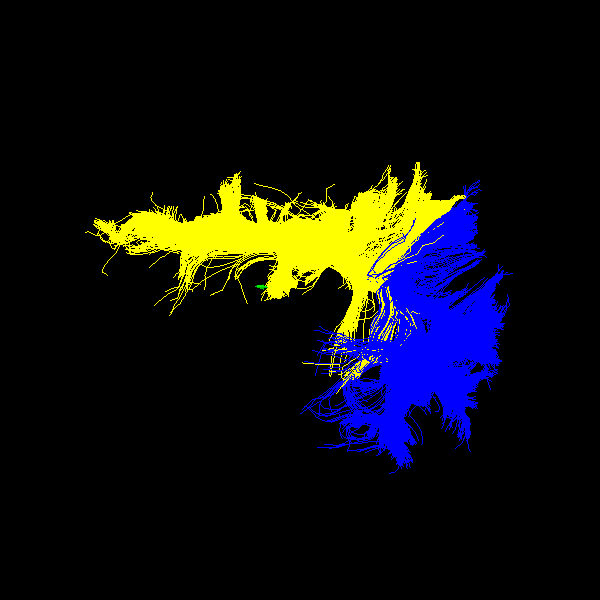

In [69]:
renpath=os.path.join(putdir, 'SLFIP_vs_SLFTP_L.png')
genren(rb_prisma_slfip_L, rb_prisma_slftp_L, putpath=renpath, show=True, colors=[(0,0,1),(1,1,0)])
Image(renpath, width=400, height=400)